In [1]:
using LinearAlgebra, Plots, Statistics, CurveFit

In [2]:
abstract type Particle end

mutable struct Big <: Particle
    pos::Vector{Float64}
end

mutable struct Small <: Particle
    pos::Vector{Float64}
end

In [3]:
function step!(p::Big, d::Float64, bound::Float64)
    θ = rand() * 2π
    p.pos += [cos(θ), sin(θ)] * d
    for i in eachindex(p.pos)
        if p.pos[i] < 0
            p.pos[i] += bound
        elseif p.pos[i] > bound
            p.pos[i] -= bound
        end
    end
    p
end
function step!(p::Small, d::Float64, bound::Float64)
    θ = rand(4) * 2π
    p.pos += [cos(θ[1]), sin(θ[1])] * d
    p.pos += [cos(θ[2]), sin(θ[2])] * d
    p.pos += [cos(θ[3]), sin(θ[3])] * d
    p.pos += [cos(θ[4]), sin(θ[4])] * d
    for i in eachindex(p.pos)
        if p.pos[i] < 0
            p.pos[i] += bound
        elseif p.pos[i] > bound
            p.pos[i] -= bound
        end
    end
    p
end

step! (generic function with 2 methods)

In [4]:
function distance(p1::Particle, p2::Particle, bound::Float64)
    candidate = Matrix{Float64}(undef, 3,3)
    for i in -1:1, j in -1:1
        candidate[i+2, j+2] = norm(p1.pos + [i,j]*bound - p2.pos)
    end
    minimum(candidate)
end

distance (generic function with 1 method)

In [5]:
overlap(p1::Big, p2::Big, bound::Float64) = distance(p1, p2, bound) < 8
overlap(p1::Big, p2::Small, bound::Float64) = distance(p1, p2, bound) < 5
overlap(p1::Small, p2::Big, bound::Float64) = distance(p1, p2, bound) < 5

function overlap(p::Big, ps::Vector{P}, bound::Float64) where P<:Particle
    for i in eachindex(ps)
        if overlap(p, ps[i], bound)
            return i
        end
    end
    return 0
end
function overlap(p::Small, ps::Vector{P}, bound::Float64) where P<:Particle
    for i in eachindex(ps)
        if typeof(ps[i]) <: Small
            continue
        end
        if overlap(p, ps[i], bound)
            return i
        end
    end
    return 0
end
function overlap(idx::Int, ps::Vector{P}, bound::Float64) where P<:Particle
    p = ps[idx]
    for i in eachindex(ps)
        if i==idx
            continue
        end
        if typeof(p) <: Small && typeof(ps[i]) <: Small
            continue
        end
        if overlap(p, ps[i], bound)
            return i
        end
    end
    return 0
end

overlap (generic function with 6 methods)

In [6]:
function step_no_overlap!(ps::Vector{P}, d::Float64, bound::Float64) where P<:Particle
    len = length(ps)
    for i in eachindex(ps)
        ov = overlap(i, ps, bound)
        if ov == 0
            step!(ps[i], d, bound)
        else
            ps[i].pos += normalize(ps[i].pos - ps[ov].pos)*d
        end
    end
    ps
end

step_no_overlap! (generic function with 1 method)

In [7]:
function run!(ps, pos1, pos2, p1, p2, N)
    for i in 1:N
        step_no_overlap!(ps, 0.5, 50.0)
        push!(pos1, p1.pos)
        push!(pos2, p2.pos)
    end
end

run! (generic function with 1 method)

In [10]:
ns = 0:10:40
N = 100_000
ret = Dict{Int, Vector{Float64}}()

#it takes few minutes
for n in ns
    print("n=$n : ")
    flush(stdout)
    ds = Float64[]
    for j in 1:10
        p1 = Big(rand(2)*50)
        p2 = Big(rand(2)*50)
        p3 = [Small(rand(2)*50) for i in 1:n]
    
        ps = [p1, p2, p3...]
        pos1 = [p1.pos]
        pos2 = [p2.pos]
        run!(ps, pos1, pos2, p1, p2, N)
    
        d = [norm(pos1[i] - pos2[i]) for i in 1:100_000] |> mean
        print("$j ")
        flush(stdout)
        push!(ds, d)
    end
    ret[n] = ds
    println()
end


n=0 : 1 2 3 4 5 6 7 8 9 10 
n=10 : 1 2 3 4 5 6 7 8 9 10 
n=20 : 1 2 3 4 5 6 7 8 9 10 
n=30 : 1 2 3 4 5 6 7 8 9 10 
n=40 : 1 2 3 4 5 6 7 8 9 10 

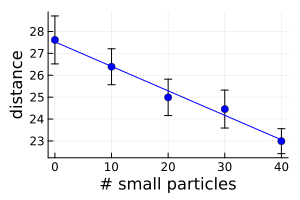

In [11]:
x = ns
y = [ret[n] |> mean for n in ns]
err = [ret[n] |> std for n in ns]
a,b = linear_fit(x, y)

plot(;ylabel = "distance", xlabel="# small particles", legend=:none, size=[300,200])
scatter!(x, y; yerror=err, c = :blue)
plot!(x->b*x+a; c=:blue)
#savefig("kokatsu.svg")
plot!()